## Summary

---

## Imports

In [1]:
import os
import tempfile
import urllib.request
from datetime import datetime
from pathlib import Path

import dotenv
import elaspic2 as el2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import seaborn as sns
import torch
from kmbio import PDB
from kmtools import structure_tools
from tqdm.auto import tqdm

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-25rrjced because the default path (/home/p/pmkim/strokach/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


## Parameters

In [2]:
NOTEBOOK_DIR = Path("39_cagi6_hmbs_submission").resolve()
NOTEBOOK_DIR.mkdir(exist_ok=True)

NOTEBOOK_DIR

PosixPath('/gpfs/fs0/scratch/p/pmkim/strokach/workspace/elaspic2-cagi6/notebooks/39_cagi6_hmbs_submission')

In [3]:
UNIPROT_ID = "P08397"

UNIPROT_ID

'P08397'

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

device(type='cpu')

In [5]:
version = datetime.now().isoformat(timespec="hours")

version

'2021-09-20T18'

## Download data

In [6]:
def download(url, filename):
    urllib.request.urlretrieve(url, filename)

In [7]:
if not NOTEBOOK_DIR.parent.joinpath("30_cagi6_hmbs", "validation.py").is_file():
    import synapseclient
    import synapseutils

    dotenv.load_dotenv("../.env")
    syn = synapseclient.Synapse()
    syn.login(os.environ["SYNAPSE_USERNAME"], os.environ["SYNAPSE_PASSWORD"])
    _ = synapseutils.syncFromSynapse(syn, "syn25823964", path=NOTEBOOK_DIR)

In [8]:
sequence_file = NOTEBOOK_DIR.parent.joinpath("30_cagi6_hmbs", f"{UNIPROT_ID}.fasta")

if not sequence_file.is_file():
    download(f"https://www.uniprot.org/uniprot/{UNIPROT_ID}.fasta", sequence_file)

In [9]:
structure_file = NOTEBOOK_DIR.parent.joinpath("30_cagi6_hmbs", f"{UNIPROT_ID}.pdb")

if not structure_file.is_file():
    download(
        f"https://alphafold.ebi.ac.uk/files/AF-{UNIPROT_ID}-F1-model_v1.pdb",
        structure_file,
    )

## Load data

In [10]:
def load_sequence(sequence_file):
    with sequence_file.open("rt") as fin:
        data = fin.read()
    chunks = []
    for line in data.split("\n"):
        if line.startswith(">"):
            continue
        chunks.append(line.strip())
    return "".join(chunks)

In [11]:
aaa_dict = {**structure_tools.constants.AAA_DICT, "TER": "*"}


def format_mutation(mutation):
    wt, pos, mut = mutation

    wt = aaa_dict[wt.upper()]
    mut = wt if mut == "=" else aaa_dict[mut.upper()]
    pos = int(pos)

    return f"{wt}{pos}{mut}"

In [12]:
def mutation_matches_sequence(mutation, sequence):
    wt, pos, mut = mutation[0], mutation[1:-1], mutation[-1]
    pos = int(pos)
    return sequence[pos - 1] == wt

In [13]:
def sequence_matches_structure(sequence, structure_blob):
    with tempfile.NamedTemporaryFile(suffix=".pdb") as tmp_file:
        with open(tmp_file.name, "wt") as fout:
            fout.write(structure_blob)
        structure = PDB.load(tmp_file.name)

    chain_sequence = structure_tools.get_chain_sequence(
        structure[0]["A"], if_unknown="replace", unknown_residue_marker=""
    )
    return sequence == chain_sequence

In [14]:
result_template_df = pd.read_csv(
    NOTEBOOK_DIR.parent.joinpath("30_cagi6_hmbs", "HMBS_variant_template.tsv"), sep="\t"
)

display(result_template_df.head(2))
len(result_template_df)

,aa_substitution,score,sd,comments
0,p.Ala112=,*,*,*
1,p.Ala112Arg,*,*,*


6894

In [15]:
result_df = result_template_df.copy()
result_df["mut"] = [
    format_mutation(mut)
    for mut in (
        result_df["aa_substitution"]
        .str.findall("p.([a-zA-Z]+)([1-9]+[0-9]*)([a-zA-Z=]+)")
        .str[0]
    )
]
result_df = result_df[
    ~result_df["mut"].str.contains("*", regex=False)
    & ~(result_df["mut"].str[0] == result_df["mut"].str[-1])
]

display(result_df.head(2))
len(result_df)

,aa_substitution,score,sd,comments,mut
1,p.Ala112Arg,*,*,*,A112R
2,p.Ala112Asn,*,*,*,A112N


6239

In [16]:
sequence = load_sequence(sequence_file)

In [17]:
assert all([mutation_matches_sequence(mut, sequence) for mut in result_df["mut"]])

In [18]:
with structure_file.open("r") as fin:
    structure_blob = fin.read()

assert sequence_matches_structure(sequence, structure_blob)

## Load `ELASPIC2` results

In [19]:
results_el2 = pq.read_table(
    NOTEBOOK_DIR.parent.joinpath("35_cagi6_hmbs_el2", "results-el2.parquet")
).to_pandas(integer_object_nulls=False)

In [20]:
display(results_el2.head(2))
print(len(results_el2))

,aa_substitution,score,sd,comments,mut,protbert_score,proteinsolver_score,el2_score
0,p.Ala112Arg,*,*,*,A112R,0.936811,0.809968,2.995820
1,p.Ala112Asn,*,*,*,A112N,0.936790,0.809852,3.083116


6239


## Load Rosetta results

In [21]:
rosetta_result_dir = NOTEBOOK_DIR.parent.joinpath("35_cagi6_hmbs_rosetta", "results")

num_files = 60
dfs = []
for i in range(1, num_files + 1):
    path = rosetta_result_dir.joinpath(f"results-rosetta-{i}-of-60.parquet")
    df = pq.read_table(path).to_pandas(integer_object_nulls=False)
    dfs.append(df)

results_rosetta_df = pd.concat(dfs, ignore_index=True)

In [22]:
display(results_rosetta_df.head(2))
print(len(results_rosetta_df))

,mut,rosetta_cart_bonded_wt,rosetta_rama_prepro_wt,rosetta_ref_wt,rosetta_hxl_tors_wt,rosetta_p_aa_pp_wt,rosetta_fa_dun_semi_wt,rosetta_fa_dun_rot_wt,rosetta_fa_dun_dev_wt,rosetta_omega_wt,...,rosetta_lk_ball_bridge_change,rosetta_lk_ball_iso_change,rosetta_lk_ball_change,rosetta_fa_intra_sol_xover4_change,rosetta_fa_intra_rep_xover4_change,rosetta_fa_intra_atr_xover4_change,rosetta_fa_sol_change,rosetta_fa_rep_change,rosetta_fa_atr_change,rosetta_dg_change
0,A112R,338.613,115.983,-68.995,166.124,-46.268,289.224,183.036,168.985,150.777,...,-0.029,-8.113333,5.208,1.644,2.230667,-1.632667,22.447667,13.662667,-22.283667,29.929333
1,A112N,338.613,115.983,-68.995,166.124,-46.268,289.224,183.036,168.985,150.777,...,-0.013,-4.872000,3.027,0.721,0.377000,-0.351000,13.670000,3.936000,-9.941000,10.370000


6239


### Visualize output

In [23]:
result_df = results_el2.merge(
    results_rosetta_df, on=["mut"], how="left", validate="1:1"
)

assert len(result_df) == len(results_el2) == len(results_rosetta_df)

In [24]:
display(result_df.head(2))
print(len(result_df))

,aa_substitution,score,sd,comments,mut,protbert_score,proteinsolver_score,el2_score,rosetta_cart_bonded_wt,rosetta_rama_prepro_wt,...,rosetta_lk_ball_bridge_change,rosetta_lk_ball_iso_change,rosetta_lk_ball_change,rosetta_fa_intra_sol_xover4_change,rosetta_fa_intra_rep_xover4_change,rosetta_fa_intra_atr_xover4_change,rosetta_fa_sol_change,rosetta_fa_rep_change,rosetta_fa_atr_change,rosetta_dg_change
0,p.Ala112Arg,*,*,*,A112R,0.936811,0.809968,2.995820,338.613,115.983,...,-0.029,-8.113333,5.208,1.644,2.230667,-1.632667,22.447667,13.662667,-22.283667,29.929333
1,p.Ala112Asn,*,*,*,A112N,0.936790,0.809852,3.083116,338.613,115.983,...,-0.013,-4.872000,3.027,0.721,0.377000,-0.351000,13.670000,3.936000,-9.941000,10.370000


6239


(array([  26.,   96.,  457., 1243., 1377., 1049.,  738.,  551.,  432.,
         270.]),
 array([-0.58611891, -0.42772953, -0.26934014, -0.11095076,  0.04743862,
         0.20582801,  0.36421739,  0.52260678,  0.68099616,  0.83938554,
         0.99777493]),
 <BarContainer object of 10 artists>)

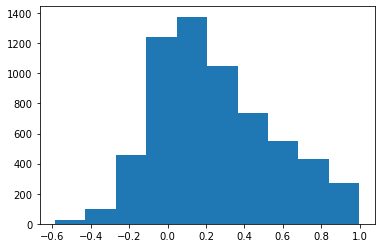

In [25]:
result_df["rosetta_score"] = np.tanh(np.clip(result_df["rosetta_dg_change"], -51, 51) / 15)

plt.hist(result_df["rosetta_score"])

In [26]:
result_df[
    ["el2_score", "proteinsolver_score", "protbert_score", "rosetta_score"]
].corr()

,el2_score,proteinsolver_score,protbert_score,rosetta_score
el2_score,1.000000,0.583297,0.796337,0.522826
proteinsolver_score,0.583297,1.000000,0.390946,0.434050
protbert_score,0.796337,0.390946,1.000000,0.315095
rosetta_score,0.522826,0.434050,0.315095,1.000000


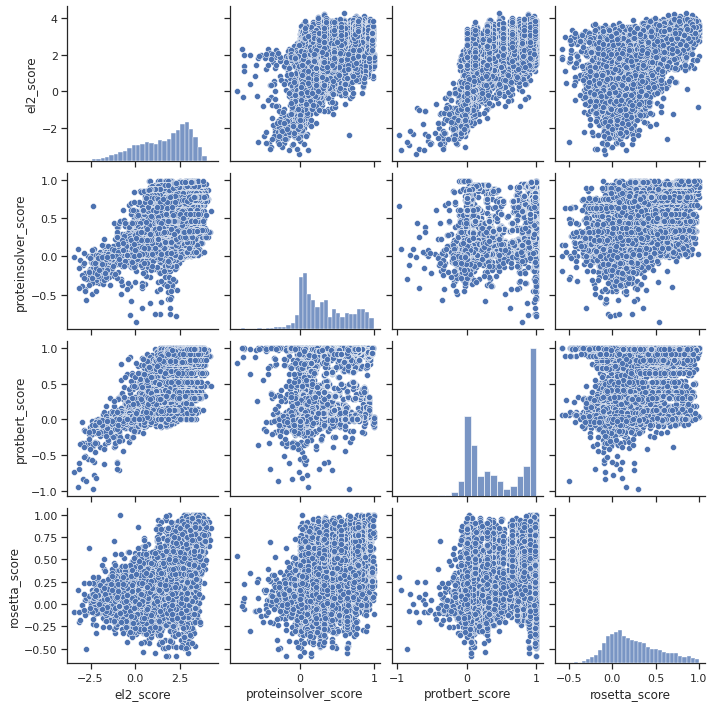

In [27]:
sns.set(style="ticks", color_codes=True)
g = sns.pairplot(
    result_df[["el2_score", "proteinsolver_score", "protbert_score", "rosetta_score"]]
)

## Write results

In [28]:
output_dir = NOTEBOOK_DIR.joinpath("submission")
output_dir.mkdir(exist_ok=True)

output_dir

PosixPath('/gpfs/fs0/scratch/p/pmkim/strokach/workspace/elaspic2-cagi6/notebooks/39_cagi6_hmbs_submission/submission')

In [29]:
%%file {output_dir}/strokach_desc.md
# Submission for CAGI6—HMBS challenge

## Overview

- `strokach_modelnumber_1.tsv` → Predictions made using ELASPIC2 [1].
- `strokach_modelnumber_2.tsv` → Predictions made using ProteinSolver [2].
- `strokach_modelnumber_3.tsv` → Predictions made using ProtBert [3].
- `strokach_modelnumber_4.tsv` → Predictions made using Rosetta's cartesian_ddg protocol.

## References

- [1] Strokach, A., Lu, T.Y., Kim, P.M., 2021. ELASPIC2 (EL2): Combining Contextualized Language Models and Graph Neural Networks to Predict Effects of Mutations. Journal of Molecular Biology, Computation Resources for Molecular Biology 433, 166810. https://doi.org/10.1016/j.jmb.2021.166810
- [2] Strokach, A., Becerra, D., Corbi-Verge, C., Perez-Riba, A., Kim, P.M., 2020. Fast and Flexible Protein Design Using Deep Graph Neural Networks. Cell Systems. https://doi.org/10.1016/j.cels.2020.08.016
- [3] Elnaggar, A., Heinzinger, M., Dallago, C., Rehawi, G., Wang, Y., Jones, L., Gibbs, T., Feher, T., Angerer, C., Steinegger, M., Bhowmik, D., Rost, B., 2020. ProtTrans: Towards Cracking the Language of Life’s Code Through Self-Supervised Deep Learning and High Performance Computing. bioRxiv 2020.07.12.199554. https://doi.org/10.1101/2020.07.12.199554

Overwriting /gpfs/fs0/scratch/p/pmkim/strokach/workspace/elaspic2-cagi6/notebooks/39_cagi6_hmbs_submission/submission/strokach_desc.md


In [30]:
display(result_template_df.head(2))
len(result_template_df)

,aa_substitution,score,sd,comments
0,p.Ala112=,*,*,*
1,p.Ala112Arg,*,*,*


6894

In [31]:
result_dfs = {}
for i, metric in enumerate(["el2", "proteinsolver", "protbert", "rosetta"]):
    result_dfs[metric] = result_template_df[["aa_substitution"]].merge(
        result_df, on=["aa_substitution"], how="left"
    )
    assert len(result_dfs[metric]) == len(result_template_df)

    result_dfs[metric]["score"] = (
        1
        - result_dfs[metric][f"{metric}_score"].values
        / result_dfs[metric][f"{metric}_score"].abs().max()
    )
    result_dfs[metric]["sd"] = 1.0
    result_dfs[metric]["comments"] = "*"

    mask_nochange = result_dfs[metric]["aa_substitution"].str.endswith("=")
    result_dfs[metric].loc[mask_nochange, "score"] = 1.0

    mask_ter = result_dfs[metric]["aa_substitution"].str.contains("Ter", regex=False)
    result_dfs[metric].loc[mask_ter, "score"] = 0.0
    result_dfs[metric].loc[mask_ter, "comments"] = "Wild guess"

    print(metric)
    display(result_dfs[metric].head())

    output_file = output_dir.joinpath(f"strokach_modelnumber_{i + 1}.tsv")
    result_dfs[metric][result_template_df.columns].to_csv(
        output_file, sep="\t", index=False
    )
    assert len(result_dfs[metric]) == len(result_template_df)

    !python {NOTEBOOK_DIR.parent}/30_cagi6_hmbs/validation.py {output_file}

el2


,aa_substitution,score,sd,comments,mut,protbert_score,proteinsolver_score,el2_score,rosetta_cart_bonded_wt,rosetta_rama_prepro_wt,...,rosetta_lk_ball_iso_change,rosetta_lk_ball_change,rosetta_fa_intra_sol_xover4_change,rosetta_fa_intra_rep_xover4_change,rosetta_fa_intra_atr_xover4_change,rosetta_fa_sol_change,rosetta_fa_rep_change,rosetta_fa_atr_change,rosetta_dg_change,rosetta_score
0,p.Ala112=,1.000000,1.0,*,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,p.Ala112Arg,0.294013,1.0,*,A112R,0.936811,0.809968,2.995820,338.613,115.983,...,-8.113333,5.208000,1.644000,2.230667,-1.632667,22.447667,13.662667,-22.283667,29.929333,0.963693
2,p.Ala112Asn,0.273442,1.0,*,A112N,0.936790,0.809852,3.083116,338.613,115.983,...,-4.872000,3.027000,0.721000,0.377000,-0.351000,13.670000,3.936000,-9.941000,10.370000,0.598838
3,p.Ala112Asp,0.218195,1.0,*,A112D,0.936767,0.810051,3.317553,338.613,115.983,...,-5.981000,3.570000,0.851000,0.128000,-0.229000,20.186000,2.628000,-7.728000,15.164000,0.766148
4,p.Ala112Cys,0.704368,1.0,*,A112C,0.911470,0.794887,1.254500,338.613,115.983,...,-0.462667,0.082333,0.066667,0.083000,-0.023667,4.757667,4.490667,-7.169667,6.359000,0.400239


The file's format is valid! You are good to submit now!
proteinsolver


,aa_substitution,score,sd,comments,mut,protbert_score,proteinsolver_score,el2_score,rosetta_cart_bonded_wt,rosetta_rama_prepro_wt,...,rosetta_lk_ball_iso_change,rosetta_lk_ball_change,rosetta_fa_intra_sol_xover4_change,rosetta_fa_intra_rep_xover4_change,rosetta_fa_intra_atr_xover4_change,rosetta_fa_sol_change,rosetta_fa_rep_change,rosetta_fa_atr_change,rosetta_dg_change,rosetta_score
0,p.Ala112=,1.000000,1.0,*,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,p.Ala112Arg,0.183368,1.0,*,A112R,0.936811,0.809968,2.995820,338.613,115.983,...,-8.113333,5.208000,1.644000,2.230667,-1.632667,22.447667,13.662667,-22.283667,29.929333,0.963693
2,p.Ala112Asn,0.183485,1.0,*,A112N,0.936790,0.809852,3.083116,338.613,115.983,...,-4.872000,3.027000,0.721000,0.377000,-0.351000,13.670000,3.936000,-9.941000,10.370000,0.598838
3,p.Ala112Asp,0.183284,1.0,*,A112D,0.936767,0.810051,3.317553,338.613,115.983,...,-5.981000,3.570000,0.851000,0.128000,-0.229000,20.186000,2.628000,-7.728000,15.164000,0.766148
4,p.Ala112Cys,0.198573,1.0,*,A112C,0.911470,0.794887,1.254500,338.613,115.983,...,-0.462667,0.082333,0.066667,0.083000,-0.023667,4.757667,4.490667,-7.169667,6.359000,0.400239


The file's format is valid! You are good to submit now!
protbert


,aa_substitution,score,sd,comments,mut,protbert_score,proteinsolver_score,el2_score,rosetta_cart_bonded_wt,rosetta_rama_prepro_wt,...,rosetta_lk_ball_iso_change,rosetta_lk_ball_change,rosetta_fa_intra_sol_xover4_change,rosetta_fa_intra_rep_xover4_change,rosetta_fa_intra_atr_xover4_change,rosetta_fa_sol_change,rosetta_fa_rep_change,rosetta_fa_atr_change,rosetta_dg_change,rosetta_score
0,p.Ala112=,1.000000,1.0,*,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,p.Ala112Arg,0.062969,1.0,*,A112R,0.936811,0.809968,2.995820,338.613,115.983,...,-8.113333,5.208000,1.644000,2.230667,-1.632667,22.447667,13.662667,-22.283667,29.929333,0.963693
2,p.Ala112Asn,0.062990,1.0,*,A112N,0.936790,0.809852,3.083116,338.613,115.983,...,-4.872000,3.027000,0.721000,0.377000,-0.351000,13.670000,3.936000,-9.941000,10.370000,0.598838
3,p.Ala112Asp,0.063013,1.0,*,A112D,0.936767,0.810051,3.317553,338.613,115.983,...,-5.981000,3.570000,0.851000,0.128000,-0.229000,20.186000,2.628000,-7.728000,15.164000,0.766148
4,p.Ala112Cys,0.088316,1.0,*,A112C,0.911470,0.794887,1.254500,338.613,115.983,...,-0.462667,0.082333,0.066667,0.083000,-0.023667,4.757667,4.490667,-7.169667,6.359000,0.400239


The file's format is valid! You are good to submit now!
rosetta


,aa_substitution,score,sd,comments,mut,protbert_score,proteinsolver_score,el2_score,rosetta_cart_bonded_wt,rosetta_rama_prepro_wt,...,rosetta_lk_ball_iso_change,rosetta_lk_ball_change,rosetta_fa_intra_sol_xover4_change,rosetta_fa_intra_rep_xover4_change,rosetta_fa_intra_atr_xover4_change,rosetta_fa_sol_change,rosetta_fa_rep_change,rosetta_fa_atr_change,rosetta_dg_change,rosetta_score
0,p.Ala112=,1.000000,1.0,*,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,p.Ala112Arg,0.034158,1.0,*,A112R,0.936811,0.809968,2.995820,338.613,115.983,...,-8.113333,5.208000,1.644000,2.230667,-1.632667,22.447667,13.662667,-22.283667,29.929333,0.963693
2,p.Ala112Asn,0.399827,1.0,*,A112N,0.936790,0.809852,3.083116,338.613,115.983,...,-4.872000,3.027000,0.721000,0.377000,-0.351000,13.670000,3.936000,-9.941000,10.370000,0.598838
3,p.Ala112Asp,0.232144,1.0,*,A112D,0.936767,0.810051,3.317553,338.613,115.983,...,-5.981000,3.570000,0.851000,0.128000,-0.229000,20.186000,2.628000,-7.728000,15.164000,0.766148
4,p.Ala112Cys,0.598869,1.0,*,A112C,0.911470,0.794887,1.254500,338.613,115.983,...,-0.462667,0.082333,0.066667,0.083000,-0.023667,4.757667,4.490667,-7.169667,6.359000,0.400239


The file's format is valid! You are good to submit now!


el2 0.0
proteinsolver 0.0
protbert 0.0
rosetta 0.0


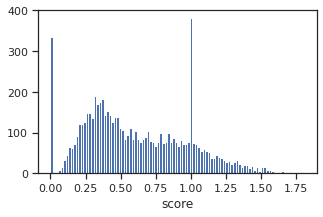

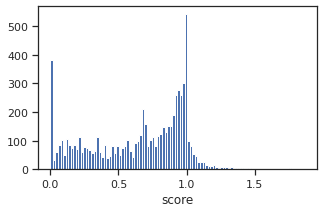

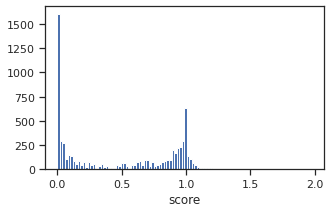

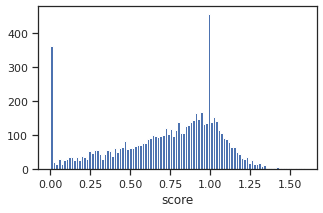

In [32]:
for metric, df in result_dfs.items():
    print(metric, df["score"].min())

    fig, ax = plt.subplots(figsize=(5, 3))
    ax.hist(df["score"], bins=100)
    ax.set_xlabel("score")